# ACTIVITY: A CLASSIFIER

The goal of this activity is to practice building and discussing a classifier. By the end of the activity, you should be able to justify your design decisions according to 

TASK:

In [1]:
import kagglehub
import os
import pandas as pd
from pathlib import Path

path = kagglehub.dataset_download("hgultekin/bbcnewsarchive")
print(os.listdir(path))
df = pd.read_csv(Path(path) / "bbc-news-data.csv", sep='\t')

['bbc-news-data.csv']


In [2]:
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


## Baseline classifier

We will start with a baseline classifier. It is a simple Bag-of-words classifier.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(df['content'], df['category'], test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     business       0.95      0.97      0.96       115
entertainment       0.97      0.94      0.96        72
     politics       0.96      0.95      0.95        76
        sport       0.99      0.99      0.99       102
         tech       0.95      0.95      0.95        80

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



## PART 1: preparation

Answer the questions below as comments in the following cell. In your answers, avoid using common sense. Use adequate jargons.

In [ ]:
#ex1

# Question 1: What is the underlying premise of the Bag-of-Words classifier, that is, why does BoW allow to classify these texts?

# Question 2: What is the underlying premise of a BERT-based classifier, that is, why should BERT embeddings be interesting to classify these texts?
# O classificador baseado em BERT utiliza embeddings para representar palavras em um espaço vetorial, onde palavras com significados semelhantes estão próximas umas das outras.
# Isso permite que o modelo capture o contexto e o significado das palavras em relação umas às outras, levando em consideração a ordem e a relação entre elas.
# Consequentemente, isso resulta em uma representação mais rica e informativa do texto, permitindo que o classificador faça previsões mais precisas sobre a categoria do texto.

### Question 1: What is the underlying premise of the Bag-of-Words classifier, that is, why does BoW allow to classify these texts?
A ideia central do modelo Bag-of-Words é que as próprias palavras e a frequência com que elas aparecem num texto trazem pistas suficientes para distingui-lo de outros. Isso acontece porque, em geral, documentos de um mesmo tema ou sentimento tendem a repetir um conjunto específico de termos e evitar aqueles que não estão ligados à sua categoria. Ao converter cada texto em um vetor de contagens, o classificador linear consegue “aprender” quais palavras são mais comuns em cada grupo e traçar fronteiras matemáticas que separam bem essas coleções de palavras. Mesmo ignorando a ordem e a estrutura das frases, esse método revela padrões de vocabulário distintos que servem de base para a classificação.

O Classificador Bag Of Words possui a premissa de armazenar as palavras de um texto em um vetor, onde cada posição do vetor representa uma palavra do vocabulário. 

Assim, o classificador pode analisar a frequência de cada palavra e determinar a categoria do texto com base na presença ou ausência dessas palavras. 

Isso permite que o modelo capture informações relevantes sobre o conteúdo do texto e faça previsões precisas sobre sua categoria.

## PART 2: action

(a) Make a classifier that uses BERT embeddings to categorize the texts in the dataset we have discussed.

(b) Make a bar plot comparing the accuracy of the BERT-based classifier to that of the Bag-of-Words classifier

(c) Use a PCA or a T-SNE plot to visualize the documents in the newsgroups dataset in the embedding space provided by BERT. Analyze the plot taking into account the confusion matrix or the classification report of your BERT-based classifier.




In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from transformers import BertTokenizer, BertModel

class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_length=512):
        self.max_length = max_length
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased')
        self.embeddings = None
        
    def fit(self, X, y=None):
        return self

    def transform(self, texts):
        embeddings = []
        for text in texts:
            inputs = self.tokenizer(
                text,
                return_tensors='pt',
                padding=True,
                truncation=True,
                max_length=self.max_length
            )
            outputs = self.model(**inputs)
            # obtém o embedding do token [CLS]
            cls_embedding = outputs.last_hidden_state[0, 0, :]
            embeddings.append(cls_embedding.detach().numpy())
        # armazena embeddings no próprio objeto
        self.embeddings = np.array(embeddings)
        return self.embeddings

pipeline = Pipeline([
    ('bert', BertTransformer()),
    ('logreg', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     business       0.97      0.96      0.96       115
entertainment       0.97      0.97      0.97        72
     politics       0.95      0.97      0.96        76
        sport       1.00      0.99      1.00       102
         tech       0.96      0.97      0.97        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



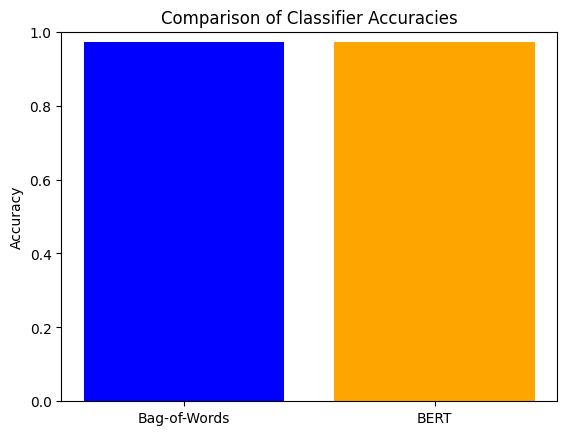

In [ ]:
import matplotlib.pyplot as plt

bow_accuracy =  .score(X_test, y_test)  
bert_accuracy = pipeline.score(X_test, y_test)  
plt.bar(['Bag-of-Words', 'BERT'], [bow_accuracy, bert_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.title('Comparison of Classifier Accuracies')
plt.ylim(0, 1)
plt.show()

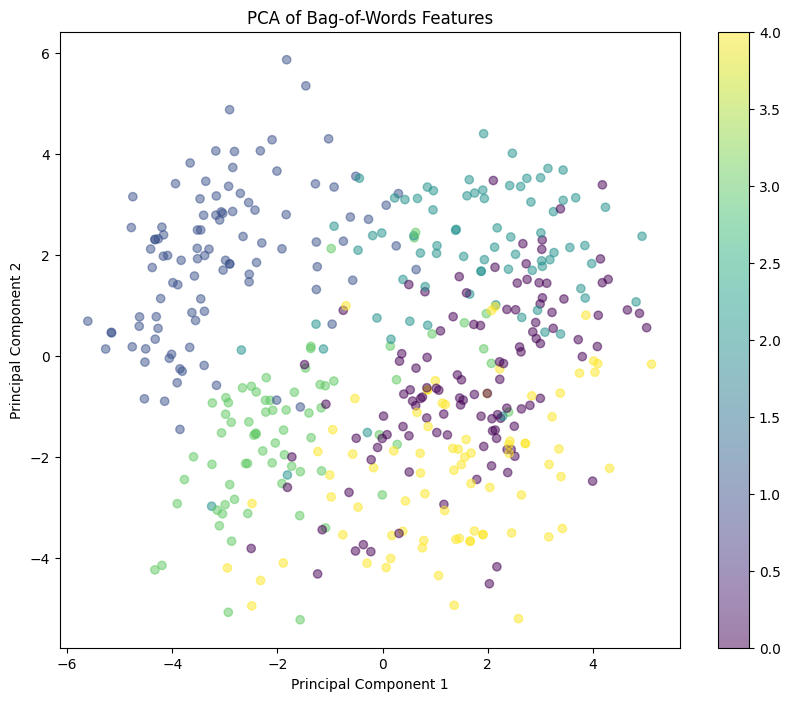

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings = np.array(pipeline.named_steps['bert'].embeddings)
e_pca = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(e_pca[:, 0], e_pca[:, 1], c=pd.factorize(y_test)[0], cmap='viridis', alpha=0.5)
plt.title('PCA of Bag-of-Words Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

Vamos simplificar ao máximo:

1. **Cada ponto = um documento**  
   Você tinha um monte de documentos (textos). O PCA pega todas as contagens de palavras (ou TF–IDF) de cada documento — que é um espaço de centenas ou milhares de dimensões — e projeta tudo em **duas** dimensões (PC1 e PC2) que retêm a maior parte da “diferença” entre documentos.

2. **Cores = classes**  
   Você já sabe a que classe cada documento pertence (0, 1, 2, 3 ou 4). A cor do ponto mostra essa classe.

3. **O que vemos**  
   - Se documentos da **mesma classe** ficam próximos uns dos outros, isso é bom: significa que eles compartilham padrões de palavras que o PCA agrupou.  
   - Se classes **diferentes** ficam bem separadas (distantes), então é fácil para um classificador (como a regressão logística) distinguir essas classes.  
   - Onde há muita **sobreposição**, o classificador tende a errar mais, porque os documentos dessas classes “parecem” semelhantes no espaço de palavras.

4. **Interpretação prática**  
   - Aqui vemos que a **classe 1** (tons de verde-azulado) forma um aglomerado no canto superior esquerdo, enquanto a **classe 4** (amarelo claro) está majoritariamente no canto inferior direito. Isso sugere que essas duas classes têm vocabulários bem diferentes.  
   - Já **classes 0 e 4** (roxo escuro e amarelo) se misturam um pouco na região inferior direita: aí o modelo pode confundir documentos dessas classes.  
   - Em suma, o gráfico mostra **quão “distintas”** as classes são quando olhamos só para as contas de palavras.

5. **Por que isso importa?**  
   - Dá uma **visão geral**: se as classes se separam bem no PCA, provavelmente seu classificador vai acertar boa parte.  
   - Identifica **pontos frágeis**: regiões com sobreposição apontam onde o modelo pode falhar.   
   - Indica se vale a pena tentar **outro método de redução ou embeddings** (por exemplo, t-SNE, UMAP, BERT) para melhorar a separação.

Em resumo, o gráfico serve para você **visualizar** como seus documentos — representados por contagens de palavras — se agrupam por classe. Onde há bom agrupamento, classificação é fácil; onde há mistura, é difícil. Isso ajuda a diagnosticar e orientar melhorias no seu pipeline de texto.

/Users/luccahiratsuca/Github/Insper/7 Semestre/nlp_course/env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


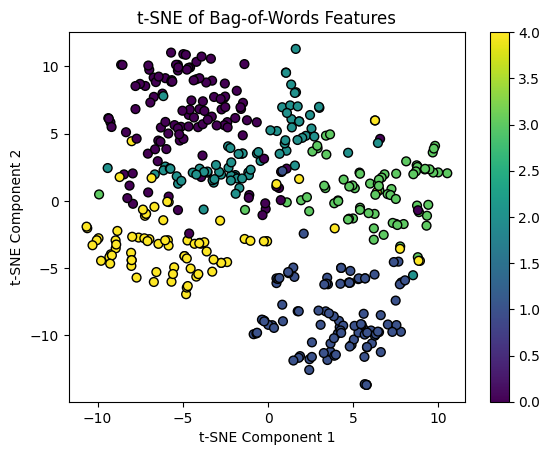

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings = np.array(pipeline.named_steps['bert'].embeddings)
e_tsne = tsne.fit_transform(embeddings)
plt.scatter(e_tsne[:, 0], e_tsne[:, 1], c=pd.factorize(y_test)[0], cmap='viridis', edgecolor='k', s=40)
plt.title('t-SNE of Bag-of-Words Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()

Esse segundo gráfico faz basicamente a mesma coisa que o PCA, só que usando **t-SNE**, um método não-linear de redução de dimensionalidade que tenta preservar as “vizinhanças” locais em vez da variância global. Vamos aos pontos-chave:

1. **Eixos sem unidade real**  
   Diferente do PCA, em que PC1 e PC2 são combinações lineares com variância explicada mensurável, os eixos do t-SNE (“t-SNE Component 1” e “t-SNE Component 2”) não têm interpretação direta além de posicionar pontos de documentos que ficam “próximos” no espaço original.

2. **Clusters mais definidos**  
   Porque o t-SNE enfatiza manter vizinhos juntos:
   - Cada cor (classe) tende a formar **aglomerados bem compactos**.
   - Por exemplo, vemos um cluster roxo-escuro (classe 0) lá no topo esquerdo, um amarelo (classe 4) em baixo à esquerda, e assim por diante.
   - Há pouquíssima sobreposição visível entre esses grupos, ao contrário do PCA, que mostrava classes mais misturadas.

3. **O que isso nos diz**  
   - **Separabilidade**: se suas classes formam aglomerados sozinhos, mesmo em BoW simples, um classificador vai encontrar padrões de palavras que permitem diferenciá-las.  
   - **Validação visual**: clusters bem definidos no t-SNE reforçam que o seu pipeline de features (bag-of-words) já captura diferenças textuais fortes entre classes.  
   - **Cuidado**: t-SNE pode criar ilusões de separação exagerada—é excelente para **visualizar**, mas não deve substituir métricas objetivas de qualidade de classificação.

4. **Como usar essa informação**  
   - Se as classes aparecem **claramente separadas**, ótimo sinal de que um modelo linear (como a sua regressão logística) pode ter bom desempenho.  
   - Se, ao contrário, dois ou mais clusters estivessem misturados, seria um indicativo de que talvez você precise de features mais sofisticadas (por exemplo embeddings BERT) ou até de pré-processamento diferente.

Em resumo: o t-SNE mostra de maneira mais “dramática” que seus documentos de classes distintas ocupam regiões diferentes no espaço de palavras. É um ótimo diagnóstico visual para confirmar (ou duvidar) da facilidade de classificação com BoW.

# PCA X T-SNE

Vamos imaginar que você tem um monte de documentos (textos) e quer uma “foto aérea” de como eles se organizam em relação uns aos outros — mas sem olhar palavra por palavra, e sim usando uma “redução” mágica de dimensões. É aí que entram PCA e t-SNE.

---

## 1. PCA (Análise de Componentes Principais)

- **O que faz**: pega todos os seus números (contagens de palavras, TF–IDF etc.), que podem ser milhares de dimensões, e traça duas “novas variáveis” (PC1 e PC2) que **explicam o máximo possível da variação** dos dados de forma linear.  
- **O que vemos no gráfico**:  
  - Eixos com interpretação: PC1 é a direção de maior diferença entre documentos, PC2 é a segunda maior, e assim por diante.  
  - Classes (cores) aparecem como “nuvens” de pontos que às vezes se sobrepõem, porque o PCA tenta resumir toda a dispersão global, não focar em separar cada grupinho.  
- **Para que serve**:  
  - Ter uma visão geral rápida de quais direções de variação são mais relevantes.  
  - Fazer compressão de dados (reduzir dimensionalidade) antes de alimentar um modelo, mantendo informação global.  
  - É **rápido** e escalável.

---

## 2. t-SNE (t-Distributed Stochastic Neighbor Embedding)

- **O que faz**: também pega as mesmas dimensões altas, mas agora tenta **manter “vizinhos de verdade” próximos** no gráfico final, sem se preocupar em explicar a variação total — ele é **não-linear** e otimiza a preservação de distâncias locais.  
- **O que vemos no gráfico**:  
  - Aglomerados muito mais compactos para cada classe (cores), quase sem sobreposição, porque o t-SNE “puxa” pontos semelhantes e “empurra” diferentes.  
  - Os eixos não têm significado matemático (não são componentes ordenadas por variação), servem só de coordenadas para mostrar os grupos.  
- **Para que serve**:  
  - **Visualização exploratória**: descobrir clusters naturais, ver se existem subgrupos escondidos.  
  - Diagnosticar se seu modelo de texto captura bem as diferenças entre categorias.  
  - É **mais lento** e sensível a parâmetros (perplexity, número de iterações).

---

## 3. Principais diferenças

| Característica       | PCA                              | t-SNE                             |
|----------------------|----------------------------------|------------------------------------|
| **Tipo**             | Linear                           | Não-linear                         |
| **Objetivo**         | Maximizar variância global       | Preservar vizinhanças locais       |
| **Interpretação**    | Eixos “componentes” mensuráveis  | Eixos arbitrários sem interpretação|
| **Separação visual** | Moderada, pode ter sobreposição  | Forte, clusters bem definidos      |
| **Velocidade**       | Rápido                           | Mais lento                         |
| **Uso comum**        | Compressão de dados, pré-processo| Exploração de clusters, diagnóstico|

---

## 4. Quando usar cada um

- **PCA**  
  - Se você quer **reduzir** suas features antes de treinar um modelo (manter o máximo de informação possível).  
  - Quando tiver **muitos** dados e precisar de rapidez.  
  - Para entender quais combinações lineares de palavras mais explicam as diferenças gerais.

- **t-SNE**  
  - Se você quer **visualizar** claramente onde estão seus grupos ou achar subgrupos inesperados.  
  - Para **explorar** dados e ter intuições sobre clusters.  
  - Quando não se importa tanto com tempo de execução, mas sim em ver agrupamentos nítidos.

---

### Em resumo para um leigo

- **PCA** é como projetar a sombra de um objeto complexo sob duas lâmpadas que revelam o máximo de detalhe global.  
- **t-SNE** é como colocar vários ímãs em bolinhas: as que se atraem (documentos semelhantes) se juntam num canto, as que se repelem (documentos diferentes) se afastam.  

Ambos ajudam a enxergar “de relance” como seus textos estão distribuídos, mas cada um tem sua ênfase: PCA para **informação global** e velocidade, t-SNE para **aglomerados locais** e clareza visual de clusters.